# Using the QLattice with small data sets

In many cases, a researcher has collected a fairly small dataset of a few hundred individuals. In this notebook we apply a systematic approach to test the performance of the QLattice against the usual go-to technologies for fitting and ML.

We compare to other **interpretable** models:
- Linear models (both with and without LASSO)
- Decision Trees

And to other **ensemble models** which are more black-box:
- Random Forest
- Gradient Boosting

In [1]:
import pandas as pd
import numpy as np
import multiprocessing
import feyn
import matplotlib.pyplot as plt
import tqdm
import time
import srsmall
import io

This Feyn package and QLattice is licensed to Casper Wilstrup, Abzu. By using this software you agree to the terms and conditions which can be found at `https://abzu.ai/eula`.


# Compare to the usual suspects

In [2]:
#results = pd.DataFrame(columns=["dataset", "model", "randomseed", "train_r2", "test_r2"])
results = pd.read_csv("results-cache-wip.csv")

In [3]:
from sklearn import tree, linear_model, ensemble

models = [
    linear_model.LinearRegression(),
#    linear_model.Lasso(alpha=0.01, max_iter=100000),
    linear_model.Lasso(alpha=0.05, max_iter=100000),
#    linear_model.Lasso(alpha=0.10, max_iter=100000),

#    tree.DecisionTreeRegressor(max_depth=1),
#    tree.DecisionTreeRegressor(max_depth=2),
#    tree.DecisionTreeRegressor(max_depth=4),
#    tree.DecisionTreeRegressor(max_depth=6),
    
#    ensemble.RandomForestRegressor(n_estimators=400),
    ensemble.RandomForestRegressor(n_estimators=200),
#    ensemble.RandomForestRegressor(n_estimators=100),
#    ensemble.RandomForestRegressor(n_estimators=50),

#    ensemble.GradientBoostingRegressor(n_estimators=400),
    ensemble.GradientBoostingRegressor(n_estimators=200),
#    ensemble.GradientBoostingRegressor(n_estimators=100),
#    ensemble.GradientBoostingRegressor(n_estimators=50),
]

In [4]:
def X(df):
    return df.iloc[:,:-1]

def y(df):
    return df.iloc[:,-1]

def fit_comparison(model, name, randomseed):
    train, test = srsmall.get_data(name, randomseed)


    model.fit(X(train), y(train))

    
    r2_train = model.score(X(train), y(train))
    r2_test = model.score(X(test), y(test))
    
    res = pd.DataFrame([{"dataset": name, "model": str(model), "randomseed": randomseed, "train_r2": r2_train, "test_r2": r2_test}])
    return res

In [5]:
# Find the jobs that need to be run
jobargs = []
for name in srsmall.small["name"]:
    for m in models:
        for seed in range(0,5):
            if ((results["dataset"]==name) & (results["model"]==str(m)) & (results["randomseed"]==seed)).any():
                continue
            else:
                jobargs.append((m,name,seed))


In [6]:
len(jobargs)

0

In [7]:
# Create a pool of workers to run in parallel
with multiprocessing.Pool(processes=6) as pool:
    # Map the function to the inputs, distributing the work across multiple processes
    reslist = pool.starmap(fit_comparison, tqdm.tqdm(jobargs, total=len(jobargs)), chunksize=1)

if (len(reslist)>0):
    results = pd.concat([results]+reslist)

0it [00:00, ?it/s]


# Fit a QModel for each data set

In [8]:
def fit_qmodel(edges, criterion, randomseed):
    global results

    key = f"QM-{edges}-{criterion}"

    for name in srsmall.small["name"]:    
        if ((results["dataset"]==name) & (results["model"]==key) & (results["randomseed"]==randomseed)).any():
            # Skip if already run
            continue

        train, test = srsmall.get_data(name, randomseed)
        ql = feyn.QLattice(randomseed)
            
        models = ql.auto_run(train, train.columns[-1], n_epochs=50, max_complexity=edges, threads=6, criterion=criterion)
        m = models[0]
        
        mfile = io.StringIO()
        m.save(mfile)
        
        r = pd.DataFrame([{"dataset": name, "model": key, "randomseed": randomseed, "train_r2": m.r2_score(train), "test_r2": m.r2_score(test), "json": mfile.getvalue()}])
        results = pd.concat([results, r])
        
        time.sleep(2) # Protect my poor cpu

In [24]:
results[(results["model"]=="QM-11-bic")]

,dataset,model,randomseed,train_r2,test_r2,json
960,1028_SWD,QM-11-bic,0,0.430690,0.363791,"{""program"": {""codes"": [""target"", ""add:2"", ""squ..."
961,1029_LEV,QM-11-bic,0,0.629694,0.535507,"{""program"": {""codes"": [""target"", ""add:2"", ""add..."
962,1030_ERA,QM-11-bic,0,0.346398,0.369628,"{""program"": {""codes"": [""target"", ""add:2"", ""tan..."
963,1191_BNG_pbc,QM-11-bic,0,0.390122,0.258891,"{""program"": {""codes"": [""target"", ""add:2"", ""add..."
964,1193_BNG_lowbwt,QM-11-bic,0,0.603440,0.535800,"{""program"": {""codes"": [""target"", ""add:2"", ""LOW..."
965,1196_BNG_pharynx,QM-11-bic,0,0.556644,0.404512,"{""program"": {""codes"": [""target"", ""tanh:1"", ""ad..."
966,1199_BNG_echoMonths,QM-11-bic,0,0.451152,0.391759,"{""program"": {""codes"": [""target"", ""tanh:1"", ""ad..."
967,1201_BNG_breastTumor,QM-11-bic,0,0.091291,0.005579,"{""program"": {""codes"": [""target"", ""squared:1"", ..."
968,1203_BNG_pwLinear,QM-11-bic,0,0.632401,0.545141,"{""program"": {""codes"": [""target"", ""multiply:2"",..."
969,1595_poker,QM-11-bic,0,0.024164,-0.030060,"{""program"": {""codes"": [""target"", ""att_3"", ""squ..."


# Fit all QModels

In [30]:
for randomseed in range(0,2):
    fit_qmodel(11, "bic", randomseed=randomseed)
#    fit_qmodel(11, "aic", randomseed=randomseed)

In [ ]:
---

In [32]:
def hist_among(models=None, datasets=None):
    if models is None:
        models = results["model"].unique()
    if datasets is None:
        datasets = results["dataset"].unique()

    for dataset in datasets:
        subset = results[(results["dataset"] == dataset) & (results["test_r2"]>-1)]
        seeds = subset["randomseed"].unique()
        for seed in seeds:
            subsubset = subset[subset["randomseed"]==seed].sort_values(by="test_r2")
            subsubset.plot.barh(x="model", y=["test_r2","train_r2"], title=dataset+" "+str(seed),figsize=(8,6))
                

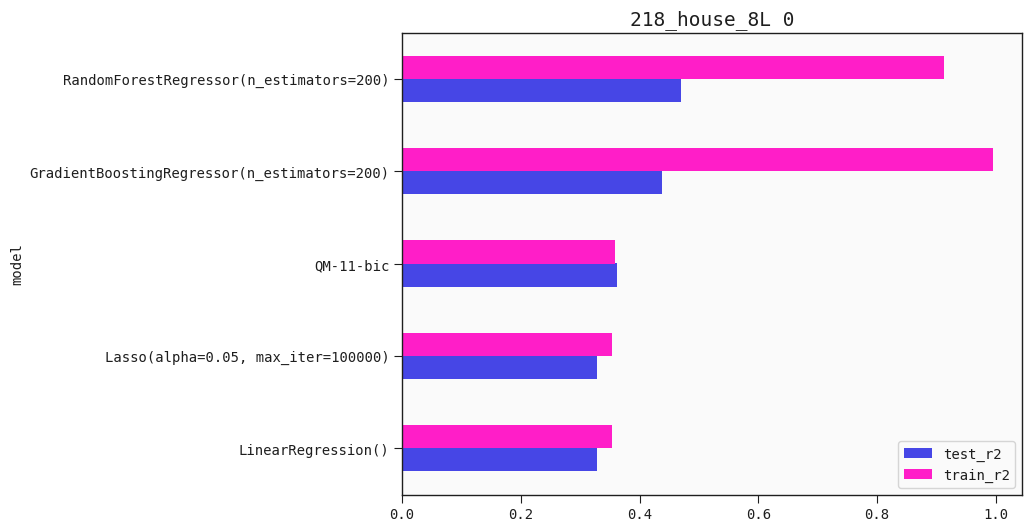

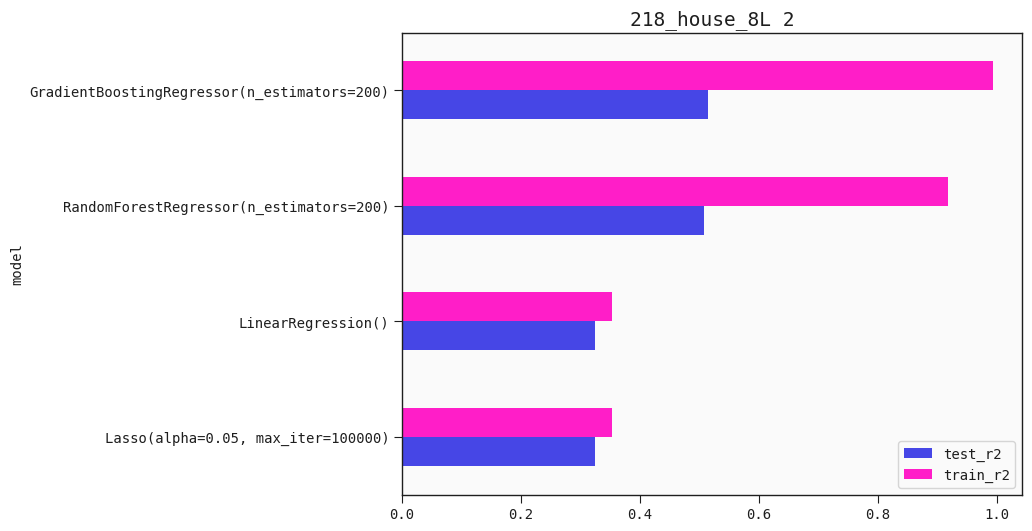

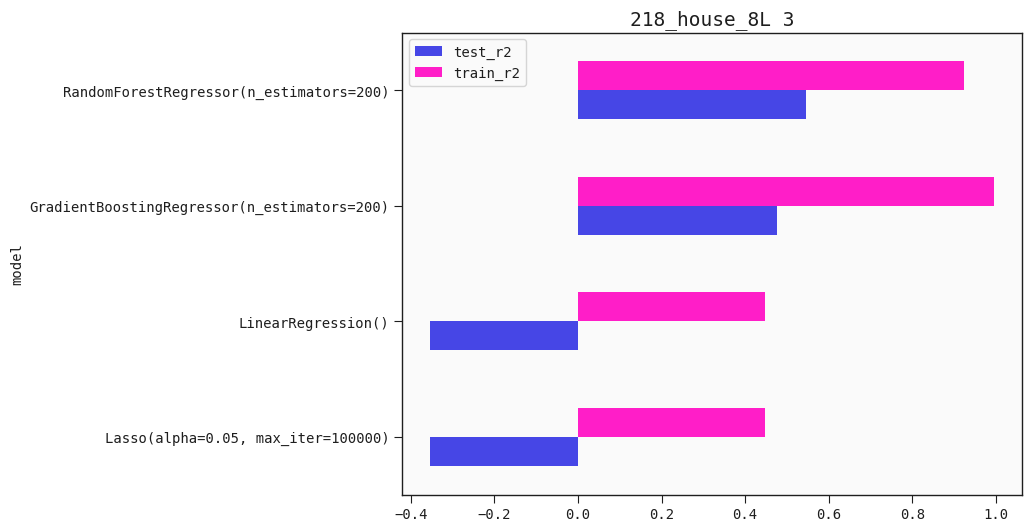

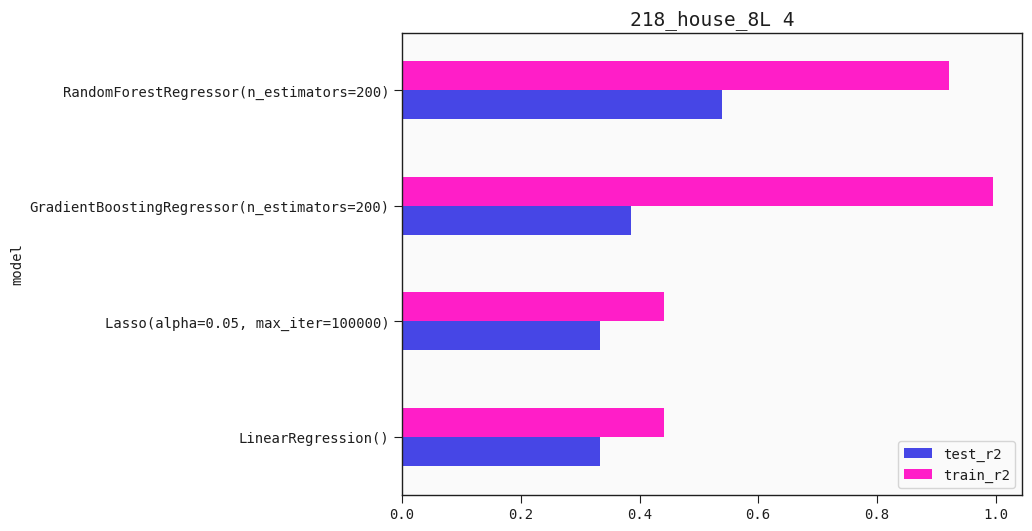

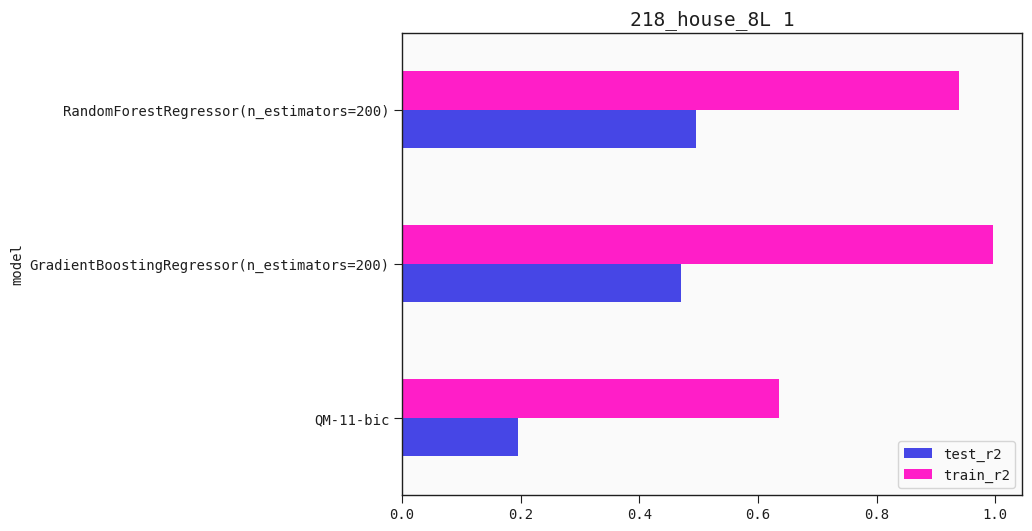

In [33]:
hist_among(None,["218_house_8L"])

In [ ]:
#for name in chosen_datasets["name"]:
#    for seed in range(0,5):
#        subres = results[(results["dataset"] == name) & (results["randomseed"]==seed) & (results["test_r2"]>-1)].sort_values(by="test_r2")
#        if len(subres):
#            subres.plot.barh(x="model", y=["test_r2","train_r2"], title=name,figsize=(8,6))

In [39]:
results.to_csv(f"results-cache-wip.csv", index=False)

# Compare all models

In [34]:
def rank_among(models=None, rankpositions = None):
    if models is None:
        models = results["model"].unique()

    if rankpositions is None:
        rankpositions = len(models)-1

    # Only consider results for the chosen models
    res = results[results["model"].isin(models)].sort_values(by="test_r2", ascending=False)
    
    points = {m: 0 for m in models}
    
    for name in res["dataset"].unique(): # For each dataset
        for seed in res["randomseed"].unique(): # For each seed
            subset = res[(res["dataset"]==name) & (res["randomseed"]==seed)]
            if len(subset):
                for rank in range(rankpositions): # For each rank position
                    m = subset.iloc[rank].model
                    r2 = subset.iloc[rank].test_r2
                    points[m] += rankpositions - rank
    return pd.DataFrame(points.items(), columns=["model", "points"]).sort_values(by="points", ascending=True)

<Axes: ylabel='model'>

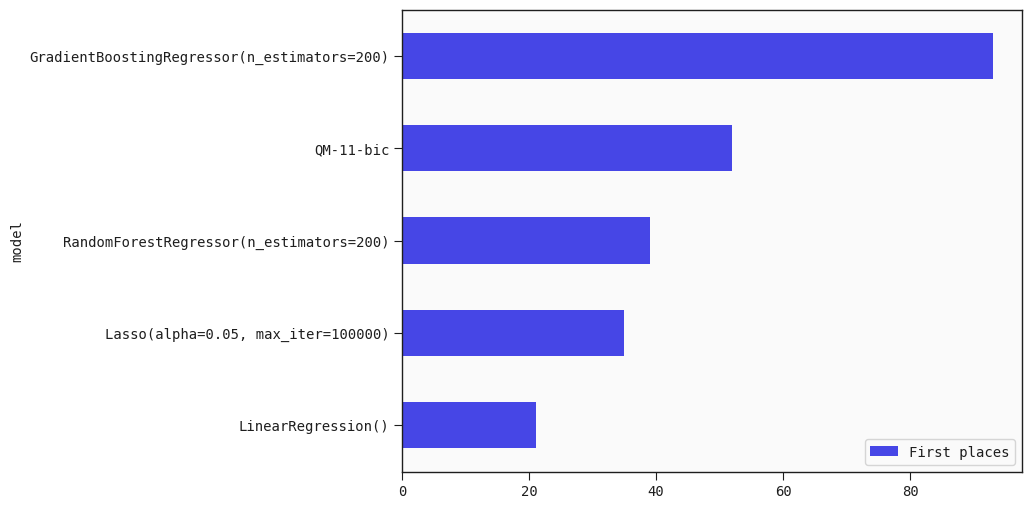

In [35]:
rank_among(rankpositions=1).plot.barh(x="model", y="points", label="First places", figsize=(8,6), xlabel="")

In [36]:
rank_among(rankpositions=1)

,model,points
0,LinearRegression(),21
1,"Lasso(alpha=0.05, max_iter=100000)",35
2,RandomForestRegressor(n_estimators=200),39
4,QM-11-bic,52
3,GradientBoostingRegressor(n_estimators=200),93


<Axes: ylabel='model'>

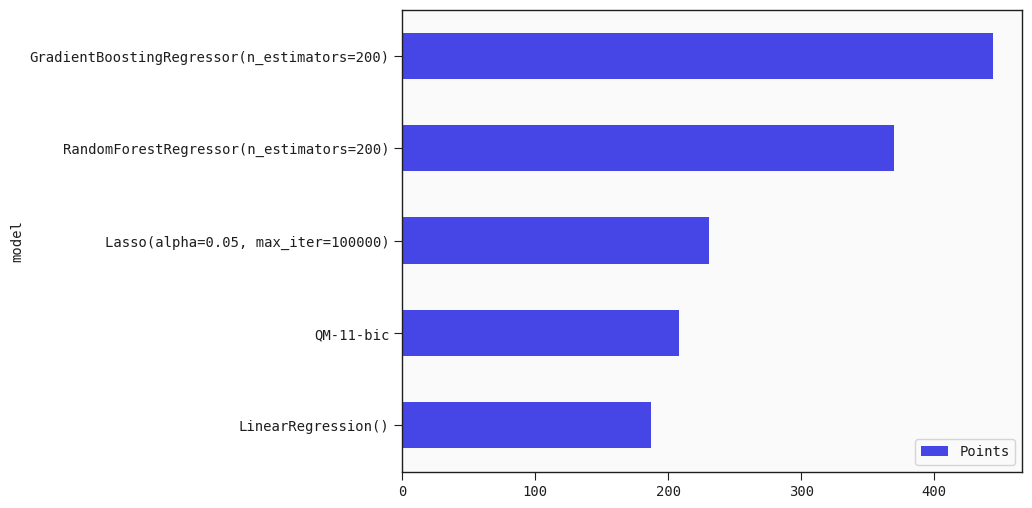

In [37]:
rank_among(rankpositions=3).plot.barh(x="model", y="points", label="Points", figsize=(8,6), xlabel="")

In [38]:
rank_among(rankpositions=3)

,model,points
0,LinearRegression(),187
4,QM-11-bic,208
1,"Lasso(alpha=0.05, max_iter=100000)",231
2,RandomForestRegressor(n_estimators=200),370
3,GradientBoostingRegressor(n_estimators=200),444


### Rankings to LaTeX table

In [ ]:
first_scoring = rank_among(rankpositions=1)
second_scoring = rank_among(rankpositions=5)
best_scoring = rank_among(
    models=["QG-11-bic", 
            "Lasso(alpha=0.1, max_iter=100000)",
            "GradientBoostingRegressor(n_estimators=400)", 
            "RandomForestRegressor(n_estimators=400)",
            "DecisionTreeRegressor(max_depth=2)"
           ],
    rankpositions=1
)
best_weighted = rank_among(
    models=["QG-11-bic", 
            "Lasso(alpha=0.1, max_iter=100000)",
            "GradientBoostingRegressor(n_estimators=400)", 
            "RandomForestRegressor(n_estimators=400)",
            "DecisionTreeRegressor(max_depth=2)"
           ],
    rankpositions=5
)

In [ ]:
first_scoring["First places"] = first_scoring.points
second_scoring["Weighted scoring"] = second_scoring.points
best_scoring["First places for best"] = best_scoring.points
best_weighted["Weighted scoring for best"] = best_weighted.points


first_scoring.index = first_scoring.model
second_scoring.index = first_scoring.model
best_scoring.index = best_scoring.model
best_weighted.index = best_weighted.model

first_scoring = first_scoring.drop(["model", "points"], axis=1)
second_scoring = second_scoring.drop(["model", "points"], axis=1)
best_scoring = best_scoring.drop(["model", "points"], axis=1)
best_weighted = best_weighted.drop(["model", "points"], axis=1)

In [ ]:
latex_results = first_scoring.join(second_scoring).join(best_scoring).join(best_weighted).sort_values(by="First places", ascending=False)
latex_results["First places for best"] = latex_results["First places for best"].replace(np.nan, 0).astype(int)
latex_results["First places for best"] = latex_results["First places for best"].replace(0, "")
latex_results["Weighted scoring for best"] = latex_results["Weighted scoring for best"].replace(np.nan, 0).astype(int)
latex_results["Weighted scoring for best"] = latex_results["Weighted scoring for best"].replace(0, "")
print(latex_results.to_latex())

### Latex formatting for the figures that we include in the article

In [ ]:
from matplotlib.colors import ListedColormap
# Use Abzu colors

abzu_rgba = {
    'Dark Jungle Green': (0.11764705882352941, 0.11764705882352941, 0.11764705882352941, 1.0),
    'Golden Yellow': (1.0, 1.0, 0.0392156862745098, 1.0),
    'Guppie Green': (0.0, 0.9411764705882353, 0.5098039215686274, 1.0),
    'Hot Magenta': (1.0, 0.11764705882352941, 0.7843137254901961, 1.0),
    'Majorelle Blue': (0.27450980392156865, 0.27450980392156865, 0.9019607843137255, 1.0),
    'Robin Egg Blue': (0.0, 0.7843137254901961, 0.7843137254901961, 1.0),
    'Safety Orange': (1.0, 0.39215686274509803, 0.0392156862745098, 1.0),
    'Spiro Disco Ball': (0.0392156862745098, 0.7058823529411765, 0.9803921568627451, 1.0)
}

def get_abzu_cmap(cname):
    r, g, b, _ = abzu_rgba[cname]
    ret = []
    for alphaval in np.linspace(0.03, 0.9, 256):
        ret.append([r, g, b, alphaval])
    return ListedColormap(np.array(ret))

In [ ]:
import matplotlib as mpl

mpl.rc('xtick',labelsize=10)
mpl.rc('ytick',labelsize=10)

mpl.rc('axes',labelsize=15)
mpl.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rc('text', usetex=True)

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))

chosen_datasets.plot.scatter(
    x="n",
    y="fcount",
    loglog=True,
    ylabel="Number of features",
    xlabel="Number of observations",
    color=abzu_rgba['Majorelle Blue'],
    s=40,
    ax=ax
)
plt.tight_layout()
#plt.savefig("/home/jaan/devel/regressionArticle/jmlr/manuscript/figures/dataset_summary.pdf")

## Search for a results figure

In [ ]:
best_models = [
    "QG-11-bic", 
    "GradientBoostingRegressor(n_estimators=400)", 
    "RandomForestRegressor(n_estimators=400)",
    "Lasso(alpha=0.01, max_iter=100000)",
    "DecisionTreeRegressor(max_depth=2)"
    ]

In [ ]:
best_results = results[results.model.isin(best_models)]

In [ ]:
best_results

In [ ]:
agg_dict = {'train_r2': 'mean', 'test_r2': 'mean'}
sr_results = best_results[best_results.model.apply(lambda x: 'QG' in x)].groupby('dataset').agg(agg_dict)
dt_results = best_results[best_results.model.apply(lambda x: 'DecisionTree' in x)].groupby('dataset').agg(agg_dict)
gb_results = best_results[best_results.model.apply(lambda x: 'GradientBoosting' in x)].groupby('dataset').agg(agg_dict)
rf_results = best_results[best_results.model.apply(lambda x: 'RandomForest' in x)].groupby('dataset').agg(agg_dict)
lr_results = best_results[best_results.model.apply(lambda x: 'Lasso' in x)].groupby('dataset').agg(agg_dict)

In [ ]:
f'{sr_results=}'.split('=')[0]

In [ ]:
(sr_results.test_r2 < 0).sum()

In [ ]:
# Number of negative test R^2 results
for name, method_df in {"sr": sr_results, "dt": dt_results, "gb": gb_results, "rf": rf_results, "lr": lr_results}.items():
    print(name, (method_df.test_r2 < 0).sum())
    
del name
del method_df

In [ ]:
def df_to_cloud(df):
    return np.vstack([df.train_r2.ravel(), df.test_r2.ravel()])

In [ ]:
Xr, Yr = np.mgrid[0:1:0.01, 0:1:0.01]
all_positions = np.vstack([Xr.ravel(), Yr.ravel()])

In [ ]:
list(abzu_rgba)

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
for sax in ax.flatten():
    sax.set_ylim(0,1)
    sax.set_xlim(0,1)
    #sax.set_xlabel(r'Train $R^2$')
    #sax.set_ylabel(r'Test $R^2$')
    
fig.text(0.5, 0.04, r'Training $R^2$', ha='center', size=20)
fig.text(0.04, 0.5, r'Validation $R^2$', va='center', rotation='vertical', size=20)

scatter_density = np.reshape(gaussian_kde(df_to_cloud(sr_results))(all_positions).T, Xr.shape)
ax[0,0].imshow(np.rot90(scatter_density), extent=[0,1,0,1], alpha=.5, cmap=get_abzu_cmap('Spiro Disco Ball'))
ax[0,0].plot(np.linspace(0,1,100), np.linspace(0,1,100), ls="--", color="black", alpha=0.4)
ax[0,0].scatter(sr_results.train_r2, sr_results.test_r2, color=abzu_rgba['Spiro Disco Ball'])
ax[0,0].set_title(r"\textbf{(A)} QLattice with BIC")

scatter_density = np.reshape(gaussian_kde(df_to_cloud(lr_results))(all_positions).T, Xr.shape)
ax[0,1].imshow(np.rot90(scatter_density), extent=[0,1,0,1], alpha=.5, cmap=get_abzu_cmap('Guppie Green'))
ax[0,1].plot(np.linspace(0,1,100), np.linspace(0,1,100), ls="--", color="black", alpha=0.4)
ax[0,1].scatter(lr_results.train_r2, lr_results.test_r2, color=abzu_rgba['Guppie Green'])
ax[0,1].set_title(r"\textbf{(B)} Lasso Regression ($\alpha=0.1$)")

scatter_density = np.reshape(gaussian_kde(df_to_cloud(dt_results))(all_positions).T, Xr.shape)
ax[0,2].imshow(np.rot90(scatter_density), extent=[0,1,0,1], alpha=.5, cmap=get_abzu_cmap('Safety Orange'))
ax[0,2].plot(np.linspace(0,1,100), np.linspace(0,1,100), ls="--", color="black", alpha=0.4)
ax[0,2].scatter(dt_results.train_r2, dt_results.test_r2, color=abzu_rgba['Safety Orange'])
ax[0,2].set_title(r"\textbf{(C)} Decision Tree (Max depth 2)")

scatter_density = np.reshape(gaussian_kde(df_to_cloud(gb_results))(all_positions).T, Xr.shape)
ax[1,0].imshow(np.rot90(scatter_density), extent=[0,1,0,1], alpha=.5, cmap=get_abzu_cmap('Hot Magenta'))
ax[1,0].plot(np.linspace(0,1,100), np.linspace(0,1,100), ls="--", color="black", alpha=0.4)
ax[1,0].scatter(gb_results.train_r2, gb_results.test_r2, color=abzu_rgba['Hot Magenta'])
ax[1,0].set_title(r"\textbf{(D)} Gradient Boosting (400)")

scatter_density = np.reshape(gaussian_kde(df_to_cloud(rf_results))(all_positions).T, Xr.shape)
ax[1,1].imshow(np.rot90(scatter_density), extent=[0,1,0,1], alpha=.5, cmap=get_abzu_cmap('Majorelle Blue'))
ax[1,1].plot(np.linspace(0,1,100), np.linspace(0,1,100), ls="--", color="black", alpha=0.4)
ax[1,1].scatter(rf_results.train_r2, rf_results.test_r2, color=abzu_rgba['Majorelle Blue'])
ax[1,1].set_title(r"\textbf{(E)} Random Forest (400)")

ax[1,2].set_axis_off()

#plt.savefig("/home/jaan/devel/regressionArticle/jmlr/manuscript/figures/scatters.pdf")